## Notebook to test an ensemble learning model of the top 3-5 model from Algorithm_Test_3

In [1]:
#Imports
import numpy as np
import pandas as pd
import sys, os, random
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (roc_auc_score, recall_score, precision_score, f1_score, matthews_corrcoef, \
                             balanced_accuracy_score, confusion_matrix,classification_report )
from pathlib import Path
from datetime import datetime
import json
import joblib


#Warning Supression
import warnings
warnings.filterwarnings("ignore", module="skopt") #Ignore scikit-optimize warning print lines
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning) #For QDA
warnings.filterwarnings("ignore", category=UserWarning) #For LightBoost

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import ML_Class_2
importlib.reload(ML_Class_2) #Ensures file is uptodate!
from src.models.ML_Class_2 import Model_Tester_V2

#Utils Import
from src.models.model_artifacts import (get_artifact_dir, load_model, load_models, save_model, save_models,)
ARTIFACT_DIR = get_artifact_dir("algorithm_test_3")
from src.models import model_specs
importlib.reload(model_specs) #Ensures file is uptodate!
from src.models.model_specs import MODEL_SPECS
from src.models.perf_utils import track_performance

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)

In [26]:
# --- Data Loading and Preprocessing --- 

#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape #Test
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)
#Feature Names for later feature analysis:
feature_names = list(df)
feature_names[:-1] #Drop Risk (y)
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [3]:
def prepare_tester(model_key, *, scaler=None, cv_folds=None):
    spec = MODEL_SPECS[model_key]
    tester = Model_Tester_V2(
        model=spec["estimator"],
        scaler=scaler,
        parameter_grid=spec["grid_large"],
        cv_folds=cv_folds or spec.get("cv_folds", 5),
        feature_names=feature_names,
        model_config=spec["config"],)
    tester.train_test_split(X, y, train_size=0.8, random_state=1945)
    if callable(tester.parameter_grid):
        tester.parameter_grid = tester.parameter_grid(tester.y_train)
    return tester

In [4]:
# --- Load ALL MODELS FROM Alogithm_Test_3.ipynb --- 


# --- DecisionTreeClassifier ---
dt = prepare_tester("dt")
load_model("dt", directory=ARTIFACT_DIR, assign_to=dt)
# dt_results = dt.evaluate(show_plots=False)

# --- RandomForestClassifier ---
rf = prepare_tester("rf")
load_model("rf", directory=ARTIFACT_DIR, assign_to=rf)
# fr_results = rf.evaluate(show_plots=False)

# --- ExtraTreesClassifier ---
et = prepare_tester("et")
load_model("et", directory=ARTIFACT_DIR, assign_to=et)
# et_results = et.evaluate(show_plots=False)

# --- BaggingClassifier ---
bag = prepare_tester("bag")
load_model("bag", directory=ARTIFACT_DIR, assign_to=bag)
# bag_results = bag.evaluate(show_plots=False)

# --- GradientBoostingClassifier ---
gb = prepare_tester("gb")
load_model("gb", directory=ARTIFACT_DIR, assign_to=gb)
# gb_results = gb.evaluate(show_plots=False)

# --- AdaBoostClassifier ---
ada = prepare_tester("ada")
load_model("ada", directory=ARTIFACT_DIR, assign_to=ada)
# ada_results = ada.evaluate(show_plots=False)

# --- QuadraticDiscriminantAnalysis ---
qda = prepare_tester("qda")
load_model("qda", directory=ARTIFACT_DIR, assign_to=qda)
# qda_results = qda.evaluate(show_plots=False)

# --- XGBClassifier ---
xgb = prepare_tester("xgb")
load_model("xgb", directory=ARTIFACT_DIR, assign_to=xgb)
# xgb_results = xgb.evaluate(show_plots=False)

# --- XGBRFClassifier ---
xgbrf = prepare_tester("xgbrf")
load_model("xgbrf", directory=ARTIFACT_DIR, assign_to=xgbrf)
# xgbrf_results = xgbrf.evaluate(show_plots=False)

# --- LGBMClassifier ---
lgbm = prepare_tester("lgbm")
load_model("lgbm", directory=ARTIFACT_DIR, assign_to=lgbm)
# lgbm_results = lgbm.evaluate(show_plots=False)

# --- CatBoostClassifier ---
cat = prepare_tester("cat")
load_model("cat", directory=ARTIFACT_DIR, assign_to=cat)
# cat_results = cat.evaluate(show_plots=False)



In [5]:
# --- Preliminary soft-voting ensemble using loaded models ---

def evaluate_voting_ensemble(
    estimators_dict,
    X_train, X_test, y_train, y_test,
    threshold: float = 0.5,
    voting: str = "soft",
    ensemble_name: str | None = None,
    pos_label: int = 1,
    verbose: bool = True,
    weights: list[float] | None = None,):
    """
    Build, fit and evaluate a VotingClassifier ensemble.

    Parameters
    ----------
    estimators_dict : dict
        Dict of {name: fitted_estimator} to include in the ensemble.
    X_train, X_test, y_train, y_test : array-like
        Train/test split (same as used to train base models).
    threshold : float, default=0.5
        Decision threshold applied to P(y=pos_label).
        Only used for soft voting.
    voting : {"soft", "hard"}, default="soft"
        Voting strategy for VotingClassifier.
    ensemble_name : str, optional
        Name for the ensemble in the results table. If None, uses
        "VotingEnsemble_" + "_".join(sorted(estimators_dict.keys())).
    pos_label : int, default=1
        Positive class label.
    verbose : bool, default=True
        If True, prints metrics, confusion matrix, and classification report.
    weights : list[float], optional
        Weights for soft/hard voting, in the same order as estimators_dict.

    Returns
    -------
    results_df : pd.DataFrame
        One-row dataframe with metrics.
    voter : VotingClassifier
        The fitted VotingClassifier instance.
    cm_df : pd.DataFrame
        Confusion matrix as a dataframe.
    cls_report : str
        Text classification report.
    """

    estimators_list = [(name, est) for name, est in estimators_dict.items()]

    if ensemble_name is None:
        ensemble_name = "VotingEnsemble_" + "_".join(sorted(estimators_dict.keys()))

    voter = VotingClassifier(
        estimators=estimators_list,
        voting=voting,
        weights=weights,
        n_jobs=-1,)

    voter.fit(X_train, y_train)

    if voting == "soft":
        proba_pos = voter.predict_proba(X_test)[:, 1]
        y_pred = (proba_pos >= threshold).astype(int)
    else:
        y_pred = voter.predict(X_test)
        proba_pos = None

    roc_auc = roc_auc_score(y_test, proba_pos) if proba_pos is not None else np.nan
    acc = np.mean(y_pred == y_test)
    recall_1 = recall_score(y_test, y_pred, pos_label=pos_label)
    precision_1 = precision_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
    cls_report = classification_report(y_test, y_pred, digits=3, zero_division=0)

    if verbose:
        print(f"Ensemble: {ensemble_name}")
        print(f"Voting: {voting}")
        if voting == "soft":
            print(f"Threshold: {threshold:.2f}")
        if weights is not None:
            print(f"Weights: {weights}")
        print(f"ROC AUC: {roc_auc:.3f}")
        print(f"Accuracy: {acc:.3f}")
        print(f"Recall (class {pos_label}): {recall_1:.3f}")
        print(f"Precision (class {pos_label}): {precision_1:.3f}")
        print(f"F1 (class {pos_label}): {f1_1:.3f}")
        print(f"MCC: {mcc:.3f}")
        print(f"Balanced Accuracy: {bal_acc:.3f}")
        print("Confusion Matrix:")
        print(cm_df)
        print("Classification Report (digits=3):")
        print(cls_report)

    results_df = pd.DataFrame([{
        "Model": ensemble_name,
        "Threshold": threshold if voting == "soft" else np.nan,
        "Acc": acc,
        "ROC_AUC": roc_auc,
        "MCC": mcc,
        "Bal_Acc": bal_acc,
        "Recall_1": recall_1,
        "Precision_1": precision_1,
        "F1_1": f1_1,}])

    return results_df, voter, cm_df, cls_report

In [6]:
# --- Vote Ensemble Model --- 

#Models
dt_ensemble = dt.best_model
rf_ensemble = rf.best_model
et_ensemble = et.best_model
bag_ensemble = bag.best_model
gb_ensemble = gb.best_model
ada_ensemble = ada.best_model
qda_ensemble = qda.best_model
xgb_ensemble = xgb.best_model
xgbrf_ensemble = xgbrf.best_model
lgbm_ensemble = lgbm.best_model
cat_ensemble = cat.best_model


#Same train/test split
X_train, X_test = xgbrf.X_train, xgbrf.X_test
y_train, y_test = xgbrf.y_train, xgbrf.y_test

#Test Example
TEST = { # (1)
    "qda": qda_ensemble,
    "ada": ada_ensemble,
    "dt": dt_ensemble,
    "rf": rf_ensemble,
    "et": et_ensemble,}


Best_Recall = { #(2)
    "qda": qda_ensemble,
    "ada": ada_ensemble,
    "dt": dt_ensemble,}

Best_Balance = { # (3)
    "rf": rf_ensemble,
    "et": et_ensemble,
    "gb": gb_ensemble,}

Best_Mid = { # (4)
    "xgbrf": xgbrf_ensemble,
    "cat": cat_ensemble,
    "dt": dt_ensemble,}

six_model_ensemble = { # (5)
    "qda": qda_ensemble,
    "ada": ada_ensemble,
    "dt":  dt_ensemble,
    "rf":  rf_ensemble,
    "et":  et_ensemble,
    "xgbrf": xgbrf_ensemble}

six_model_ensemble2 = { # (6)
    "qda": qda_ensemble,
    "ada": ada_ensemble,
    "dt":  dt_ensemble,
    "rf":  rf_ensemble,
    "et":  et_ensemble,
    "gb": gb_ensemble,}


In [7]:
# --- Vote Ensemble Model --- 

#Models
dt_ensemble = dt.best_model
rf_ensemble = rf.best_model
et_ensemble = et.best_model
bag_ensemble = bag.best_model
gb_ensemble = gb.best_model
ada_ensemble = ada.best_model
qda_ensemble = qda.best_model
xgb_ensemble = xgb.best_model
xgbrf_ensemble = xgbrf.best_model
lgbm_ensemble = lgbm.best_model
cat_ensemble = cat.best_model


#Same train/test split
X_train, X_test = xgbrf.X_train, xgbrf.X_test
y_train, y_test = xgbrf.y_train, xgbrf.y_test

#Test Example
TEST = { # (1)
    "qda": qda_ensemble,
    "ada": ada_ensemble,
    "dt": dt_ensemble,
    "rf": rf_ensemble,
    "et": et_ensemble,}


Best_Recall = { #(2)
    "qda": qda_ensemble,
    "ada": ada_ensemble,
    "dt": dt_ensemble,}

Best_Balance = { # (3)
    "rf": rf_ensemble,
    "et": et_ensemble,
    "gb": gb_ensemble,}

Best_Mid = { # (4)
    "xgbrf": xgbrf_ensemble,
    "cat": cat_ensemble,
    "dt": dt_ensemble,}

six_model_ensemble = { # (5)
    "qda": qda_ensemble,
    "ada": ada_ensemble,
    "dt":  dt_ensemble,
    "rf":  rf_ensemble,
    "et":  et_ensemble,
    "xgbrf": xgbrf_ensemble}

six_model_ensemble2 = { # (6)
    "qda": qda_ensemble,
    "ada": ada_ensemble,
    "dt":  dt_ensemble,
    "rf":  rf_ensemble,
    "et":  et_ensemble,
    "gb": gb_ensemble,}

#Run evaluations
res1, voter, cm1, rep1 = evaluate_voting_ensemble(
    TEST, X_train, X_test, y_train, y_test,
    threshold=0.5, voting="soft",
    ensemble_name="TEST")

res2, voter2, cm2, rep2 = evaluate_voting_ensemble(
    Best_Recall, X_train, X_test, y_train, y_test,
    threshold=0.5, voting="soft",
    ensemble_name="Best_Recall")

res3, voter3, cm3, rep3 = evaluate_voting_ensemble(
    Best_Balance, X_train, X_test, y_train, y_test,
    threshold=0.5, voting="soft",
    ensemble_name="Best_Balance")

res4, voter4, cm4, rep4 = evaluate_voting_ensemble(
    Best_Mid, X_train, X_test, y_train, y_test,
    threshold=0.5, voting="soft",
    ensemble_name="Best_Mid")

res5, voter5, cm5, rep5 = evaluate_voting_ensemble(
    six_model_ensemble, X_train, X_test, y_train, y_test,
    threshold=0.5, voting="soft",
    ensemble_name="Six Model Ensemble")

res6, voter6, cm6, rep6 = evaluate_voting_ensemble(
    six_model_ensemble2, X_train, X_test, y_train, y_test,
    threshold=0.5, voting="soft",
    ensemble_name="Six Model Ensemble (2)")

Ensemble: TEST
Voting: soft
Threshold: 0.50
ROC AUC: 0.836
Accuracy: 0.826
Recall (class 1): 0.660
Precision (class 1): 0.579
F1 (class 1): 0.617
MCC: 0.506
Balanced Accuracy: 0.765
Confusion Matrix:
        Pred 0  Pred 1
True 0     161      24
True 1      17      33
Classification Report (digits=3):
              precision    recall  f1-score   support

           0      0.904     0.870     0.887       185
           1      0.579     0.660     0.617        50

    accuracy                          0.826       235
   macro avg      0.742     0.765     0.752       235
weighted avg      0.835     0.826     0.830       235

Ensemble: Best_Recall
Voting: soft
Threshold: 0.50
ROC AUC: 0.817
Accuracy: 0.796
Recall (class 1): 0.680
Precision (class 1): 0.515
F1 (class 1): 0.586
MCC: 0.462
Balanced Accuracy: 0.754
Confusion Matrix:
        Pred 0  Pred 1
True 0     153      32
True 1      16      34
Classification Report (digits=3):
              precision    recall  f1-score   support

     

In [8]:
# Decision Threshold Comparison for Best_Recall
thresholds = np.arange(0, 1.05, 0.05).tolist()
rows = []

proba_2 = voter2.predict_proba(X_test)[:, 1]
for t in thresholds:
    y_pred = (proba_2 >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    rows.append({
        "threshold": t,
        "recall": recall_score(y_test, y_pred, pos_label=1),
        "precision": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "false_negatives": fn,
        "accuracy": (tp + tn) / (tp + tn + fp + fn),
        "f1": f1_score(y_test, y_pred, average="macro"),})
threshold_results = pd.DataFrame(rows)
threshold_results


,threshold,recall,precision,false_negatives,accuracy,f1
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,0.96,0.225352,2,0.289362,0.279128
2,0.10,0.94,0.239796,3,0.353191,0.351771
3,0.15,0.94,0.252688,3,0.395745,0.395734
4,0.20,0.92,0.306667,4,0.540426,0.530000
5,0.25,0.90,0.321429,5,0.574468,0.558271
6,0.30,0.90,0.340909,5,0.608511,0.587531
7,0.35,0.88,0.366667,6,0.651064,0.622157
8,0.40,0.82,0.414141,9,0.714894,0.670806
9,0.45,0.72,0.439024,14,0.744681,0.683970


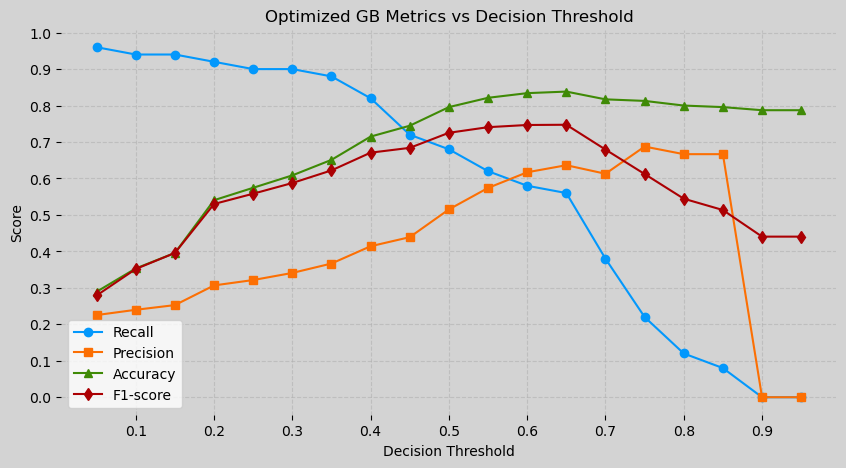

In [9]:
#Results from above minus 0.00 and 1.00
df = threshold_results.iloc[1: -1].reset_index(drop = True)

#Plot Threshold Results:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='lightgrey')
ax.set_facecolor('lightgrey')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.plot(df["threshold"], df["recall"], label="Recall", marker='o', color='#0398fc')
ax.plot(df["threshold"], df["precision"], label="Precision", marker='s', color='#fc6f03')
ax.plot(df["threshold"], df["accuracy"], label="Accuracy", marker='^', color='#3f8a06')
ax.plot(df["threshold"], df["f1"], label="F1-score", marker='d', color='#ab0003')
plt.title("Optimized GB Metrics vs Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend()
# plt.tight_layout()
# plt.savefig('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/Optimized_GB_Threshold_Results')
plt.show()

In [10]:
# Decision Threshold Comparison for Best_Balance
thresholds = np.arange(0, 1.05, 0.05).tolist()
rows = []

proba_2 = voter3.predict_proba(X_test)[:, 1]
for t in thresholds:
    y_pred = (proba_2 >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    rows.append({
        "threshold": t,
        "recall": recall_score(y_test, y_pred, pos_label=1),
        "precision": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "false_negatives": fn,
        "accuracy": (tp + tn) / (tp + tn + fp + fn),
        "f1": f1_score(y_test, y_pred, average="macro"),})
threshold_results = pd.DataFrame(rows)
threshold_results


,threshold,recall,precision,false_negatives,accuracy,f1
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,0.98,0.242574,1,0.344681,0.341233
2,0.10,0.90,0.271084,5,0.463830,0.460302
3,0.15,0.86,0.318519,7,0.578723,0.558748
4,0.20,0.82,0.394231,9,0.693617,0.652310
5,0.25,0.76,0.452381,12,0.753191,0.697273
6,0.30,0.70,0.479452,15,0.774468,0.708184
7,0.35,0.66,0.507692,17,0.791489,0.717942
8,0.40,0.66,0.578947,17,0.825532,0.751937
9,0.45,0.64,0.615385,18,0.838298,0.762095


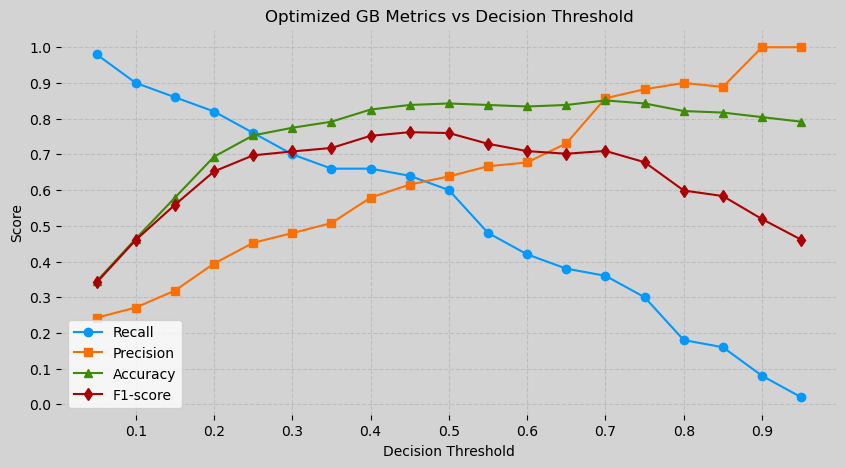

In [11]:
#Results from above minus 0.00 and 1.00
df = threshold_results.iloc[1: -1].reset_index(drop = True)

#Plot Threshold Results:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='lightgrey')
ax.set_facecolor('lightgrey')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.plot(df["threshold"], df["recall"], label="Recall", marker='o', color='#0398fc')
ax.plot(df["threshold"], df["precision"], label="Precision", marker='s', color='#fc6f03')
ax.plot(df["threshold"], df["accuracy"], label="Accuracy", marker='^', color='#3f8a06')
ax.plot(df["threshold"], df["f1"], label="F1-score", marker='d', color='#ab0003')
plt.title("Optimized GB Metrics vs Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend()
# plt.tight_layout()
# plt.savefig('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/Optimized_GB_Threshold_Results')
plt.show()

In [12]:
# Decision Threshold Comparison for Best_Mid
thresholds = np.arange(0, 1.05, 0.05).tolist()
rows = []

proba_2 = voter3.predict_proba(X_test)[:, 1]
for t in thresholds:
    y_pred = (proba_2 >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    rows.append({
        "threshold": t,
        "recall": recall_score(y_test, y_pred, pos_label=1),
        "precision": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "false_negatives": fn,
        "accuracy": (tp + tn) / (tp + tn + fp + fn),
        "f1": f1_score(y_test, y_pred, average="macro"),})
threshold_results = pd.DataFrame(rows)
threshold_results

,threshold,recall,precision,false_negatives,accuracy,f1
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,0.98,0.242574,1,0.344681,0.341233
2,0.10,0.90,0.271084,5,0.463830,0.460302
3,0.15,0.86,0.318519,7,0.578723,0.558748
4,0.20,0.82,0.394231,9,0.693617,0.652310
5,0.25,0.76,0.452381,12,0.753191,0.697273
6,0.30,0.70,0.479452,15,0.774468,0.708184
7,0.35,0.66,0.507692,17,0.791489,0.717942
8,0.40,0.66,0.578947,17,0.825532,0.751937
9,0.45,0.64,0.615385,18,0.838298,0.762095


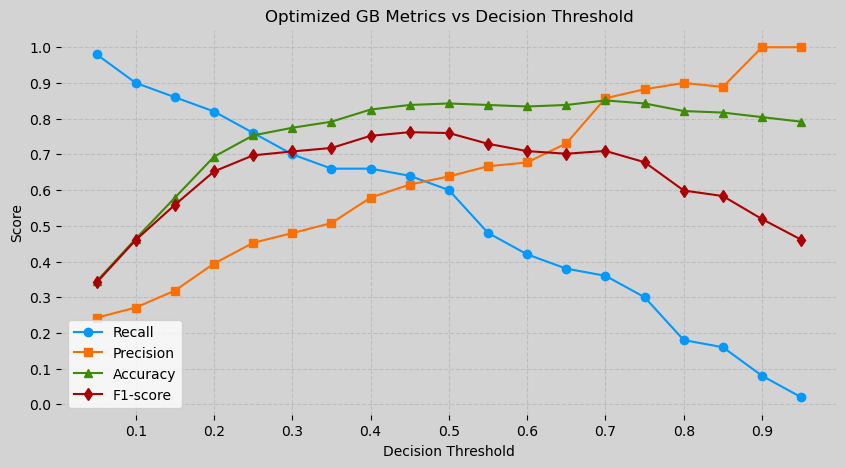

In [13]:
#Results from above minus 0.00 and 1.00
df = threshold_results.iloc[1: -1].reset_index(drop = True)

#Plot Threshold Results:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='lightgrey')
ax.set_facecolor('lightgrey')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.plot(df["threshold"], df["recall"], label="Recall", marker='o', color='#0398fc')
ax.plot(df["threshold"], df["precision"], label="Precision", marker='s', color='#fc6f03')
ax.plot(df["threshold"], df["accuracy"], label="Accuracy", marker='^', color='#3f8a06')
ax.plot(df["threshold"], df["f1"], label="F1-score", marker='d', color='#ab0003')
plt.title("Optimized GB Metrics vs Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend()
# plt.tight_layout()
# plt.savefig('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/Optimized_GB_Threshold_Results')
plt.show()

**Six Model Ensemble Tests:**

In [14]:
# --- Sixe Model Ensemble ---

six_model_ensemble = {
    "qda": qda_ensemble,
    "ada": ada_ensemble,
    "dt":  dt_ensemble,
    "rf":  rf_ensemble,
    "et":  et_ensemble,
    "xgbrf": xgbrf_ensemble}



# Uses evaluate_voting_ensemble defined above.

#Evaluate Six Model Ensemble (Hard vs Soft, Unweighted)

#Hard voting (no threshold / ROC_AUC will be NaN in your function)
res_hard, voter_hard, cm_hard, rep_hard = evaluate_voting_ensemble(
    six_model_ensemble, X_train, X_test, y_train, y_test,
    voting="hard", ensemble_name="SixModel_Hard")

#Soft voting with default threshold=0.50
res_soft_050, voter_soft_050, cm_soft_050, rep_soft_050 = evaluate_voting_ensemble(
    six_model_ensemble, X_train, X_test, y_train, y_test,
    threshold=0.50, voting="soft", ensemble_name="SixModel_Soft_t050")


#Soft Voting Threshold Test

thresholds = np.arange(0.05, 0.96, 0.05)
rows = []
voters = {}

for t in thresholds:
    r, v, _, _ = evaluate_voting_ensemble(
        six_model_ensemble, X_train, X_test, y_train, y_test,
        threshold=float(t), voting="soft",
        ensemble_name=f"SixModel_Soft_t{t:.2f}",
        verbose=False)
    rows.append(r.iloc[0].to_dict())
    voters[float(t)] = v

six_soft_threshold_results = pd.DataFrame(rows).sort_values(
    by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])
six_soft_threshold_results


#Weighted Soft Voting(same 6 models, try multiple weight sets)

#Weight sets: adjust as needed
#Order must match estimators_dict insertion order in six_model_ensemble
names = list(six_model_ensemble.keys())
print("Estimator order used for weights:", names)

weight_sets = {
    "w_equal":   [1, 1, 1, 1, 1, 1],
    "w_recall":  [3, 3, 2, 2, 2, 2],  #heavier QDA/Ada/DT
    "w_stable":  [2, 2, 1, 3, 3, 2],  #heavier RF/ET
    "w_custom1": [3, 3, 2, 3, 3, 2],  #heavier QDA/Ada + RF/ET
}
weighted_rows = []

for tag, wts in weight_sets.items():
    #Optional: sweep thresholds for each weight set
    for t in [0.30, 0.40, 0.50, 0.60]:
        r, v, _, _ = evaluate_voting_ensemble(
            six_model_ensemble, X_train, X_test, y_train, y_test,
            threshold=t, voting="soft",
            ensemble_name=f"SixModel_WeightedSoft_{tag}_t{t:.2f}",
            verbose=False,
            weights=wts)
        out = r.iloc[0].to_dict()
        out["WeightsTag"] = tag
        out["Weights"] = wts
        weighted_rows.append(out)

weighted_results = pd.DataFrame(weighted_rows).sort_values(
    by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])
weighted_results

#Calibrated Soft Votinh (calibrate base models, then soft vote)

#Calibrate each estimator on training set
calibrated_six = {}
for name, est in six_model_ensemble.items():
    # sigmoid is usually more stable than isotonic on smaller data
    cal = CalibratedClassifierCV(est, method="sigmoid", cv=3)
    cal.fit(X_train, y_train)
    calibrated_six[name] = cal

#Evaluate calibrated soft voting with threshold sweep
cal_rows = []
for t in thresholds:
    r, _, _, _ = evaluate_voting_ensemble(
        calibrated_six, X_train, X_test, y_train, y_test,
        threshold=float(t), voting="soft",
        ensemble_name=f"SixModel_CalSoft_t{t:.2f}",
        verbose=False)
    cal_rows.append(r.iloc[0].to_dict())

calibrated_soft_results = pd.DataFrame(cal_rows).sort_values(
    by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])
calibrated_soft_results

#Stacking (same 6 models)
#Note: StackingClassifier will refit base estimators internally.

def evaluate_stacking_ensemble(
    estimators_dict,
    X_train, X_test, y_train, y_test,
    final_estimator=None,
    stack_method="predict_proba",   #use probabilities from base models
    threshold=0.5,
    passthrough=False,
    ensemble_name="SixModel_Stacking",
    pos_label=1,
    verbose=False,):
    estimators_list = [(name, est) for name, est in estimators_dict.items()]
    if final_estimator is None:
        final_estimator = LogisticRegression(max_iter=2000)

    stacker = StackingClassifier(
        estimators=estimators_list,
        final_estimator=final_estimator,
        stack_method=stack_method,
        passthrough=passthrough,
        n_jobs=-1,
        cv=5, )

    stacker.fit(X_train, y_train)

    proba_pos = stacker.predict_proba(X_test)[:, pos_label]
    y_pred = (proba_pos >= threshold).astype(int)

    roc_auc = roc_auc_score(y_test, proba_pos)
    acc = np.mean(y_pred == y_test)
    recall_1 = recall_score(y_test, y_pred, pos_label=pos_label)
    precision_1 = precision_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
    cls_report = classification_report(y_test, y_pred, digits=3, zero_division=0)

    if verbose:
        print(f"Ensemble: {ensemble_name}")
        print(f"Stack method: {stack_method}, passthrough={passthrough}, threshold={threshold:.2f}")
        print(f"ROC AUC: {roc_auc:.3f}")
        print(f"Accuracy: {acc:.3f}")
        print(f"Recall (class {pos_label}): {recall_1:.3f}")
        print(f"Precision (class {pos_label}): {precision_1:.3f}")
        print(f"F1 (class {pos_label}): {f1_1:.3f}")
        print(f"MCC: {mcc:.3f}")
        print(f"Balanced Accuracy: {bal_acc:.3f}")
        print("\nConfusion Matrix:")
        print(cm_df)
        print("\nClassification Report (digits=3):")
        print(cls_report)

    results_df = pd.DataFrame([{
        "Model": ensemble_name,
        "Threshold": threshold,
        "Acc": acc,
        "ROC_AUC": roc_auc,
        "MCC": mcc,
        "Bal_Acc": bal_acc,
        "Recall_1": recall_1,
        "Precision_1": precision_1,
        "F1_1": f1_1,}])

    return results_df, stacker, cm_df, cls_report

#Stacking with LogisticRegression meta-model, threshold sweep
stack_rows = []
stackers = {}
for t in thresholds:
    r, s, _, _ = evaluate_stacking_ensemble(
        six_model_ensemble, X_train, X_test, y_train, y_test,
        final_estimator=LogisticRegression(max_iter=2000),
        passthrough=False,
        threshold=float(t),
        ensemble_name=f"SixModel_Stack_LR_t{t:.2f}",
        verbose=False)
    stack_rows.append(r.iloc[0].to_dict())
    stackers[float(t)] = s

stack_lr_results = pd.DataFrame(stack_rows).sort_values(
    by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])
stack_lr_results

#Stacking with passthrough=True (meta-model sees original features too)
stack_pt_rows = []
for t in thresholds:
    r, _, _, _ = evaluate_stacking_ensemble(
        six_model_ensemble, X_train, X_test, y_train, y_test,
        final_estimator=LogisticRegression(max_iter=2000),
        passthrough=True,
        threshold=float(t),
        ensemble_name=f"SixModel_Stack_LR_PT_t{t:.2f}",
        verbose=False)
    stack_pt_rows.append(r.iloc[0].to_dict())

stack_lr_pt_results = pd.DataFrame(stack_pt_rows).sort_values(
    by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])
stack_lr_pt_results

# --- Final Summary Comparison --- 

summary = pd.concat([
    res_hard,
    res_soft_050,
    weighted_results.head(5)[[c for c in res_soft_050.columns if c in weighted_results.columns]],
    calibrated_soft_results.head(5)[res_soft_050.columns],
    stack_lr_results.head(5)[res_soft_050.columns],
    stack_lr_pt_results.head(5)[res_soft_050.columns],], ignore_index=True)

summary.sort_values(by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])

Ensemble: SixModel_Hard
Voting: hard
ROC AUC: nan
Accuracy: 0.821
Recall (class 1): 0.660
Precision (class 1): 0.569
F1 (class 1): 0.611
MCC: 0.498
Balanced Accuracy: 0.762
Confusion Matrix:
        Pred 0  Pred 1
True 0     160      25
True 1      17      33
Classification Report (digits=3):
              precision    recall  f1-score   support

           0      0.904     0.865     0.884       185
           1      0.569     0.660     0.611        50

    accuracy                          0.821       235
   macro avg      0.736     0.762     0.748       235
weighted avg      0.833     0.821     0.826       235

Ensemble: SixModel_Soft_t050
Voting: soft
Threshold: 0.50
ROC AUC: 0.833
Accuracy: 0.796
Recall (class 1): 0.660
Precision (class 1): 0.516
F1 (class 1): 0.579
MCC: 0.453
Balanced Accuracy: 0.746
Confusion Matrix:
        Pred 0  Pred 1
True 0     154      31
True 1      17      33
Classification Report (digits=3):
              precision    recall  f1-score   support

       

,Model,Threshold,Acc,ROC_AUC,MCC,Bal_Acc,Recall_1,Precision_1,F1_1
7,SixModel_CalSoft_t0.05,0.05,0.212766,0.816324,0.000000,0.500000,1.00,0.212766,0.350877
17,SixModel_Stack_LR_PT_t0.05,0.05,0.348936,0.835892,0.184259,0.579189,0.98,0.243781,0.390438
12,SixModel_Stack_LR_t0.05,0.05,0.208511,0.830054,-0.125746,0.490000,0.98,0.209402,0.345070
8,SixModel_CalSoft_t0.10,0.10,0.365957,0.816324,0.180125,0.582703,0.96,0.246154,0.391837
18,SixModel_Stack_LR_PT_t0.10,0.10,0.570213,0.835892,0.331779,0.697838,0.92,0.321678,0.476684
2,SixModel_WeightedSoft_w_recall_t0.30,0.30,0.621277,0.832541,0.366780,0.722973,0.90,0.348837,0.502793
13,SixModel_Stack_LR_t0.10,0.10,0.570213,0.830054,0.318357,0.690541,0.90,0.319149,0.471204
3,SixModel_WeightedSoft_w_stable_t0.30,0.30,0.651064,0.834703,0.384131,0.734595,0.88,0.366667,0.517647
4,SixModel_WeightedSoft_w_equal_t0.30,0.30,0.608511,0.832973,0.341739,0.707568,0.88,0.338462,0.488889
9,SixModel_CalSoft_t0.15,0.15,0.591489,0.816324,0.325325,0.696757,0.88,0.328358,0.478261


In [15]:
# --- Five Model Ensemble ---

five_model_ensemble = { # (1)
    "qda": qda_ensemble,
    "ada": ada_ensemble,
    "dt": dt_ensemble,
    "rf": rf_ensemble,
    "et": et_ensemble,}

# Uses evaluate_voting_ensemble defined above.

#Evaluate Five Model Ensemble (Hard vs Soft, Unweighted)

#Hard voting (no threshold / ROC_AUC will be NaN in your function)
res_hard, voter_hard, cm_hard, rep_hard = evaluate_voting_ensemble(
    five_model_ensemble, X_train, X_test, y_train, y_test,
    voting="hard", ensemble_name="FiveModel_Hard")

#Soft voting with default threshold=0.50
res_soft_050, voter_soft_050, cm_soft_050, rep_soft_050 = evaluate_voting_ensemble(
    five_model_ensemble, X_train, X_test, y_train, y_test,
    threshold=0.50, voting="soft", ensemble_name="FiveModel_Soft_t050")


#Soft Voting Threshold Test

thresholds = np.arange(0.05, 0.96, 0.05)
rows = []
voters = {}

for t in thresholds:
    r, v, _, _ = evaluate_voting_ensemble(
        five_model_ensemble, X_train, X_test, y_train, y_test,
        threshold=float(t), voting="soft",
        ensemble_name=f"FiveModel_Soft_t{t:.2f}",
        verbose=False)
    rows.append(r.iloc[0].to_dict())
    voters[float(t)] = v

five_soft_threshold_results = pd.DataFrame(rows).sort_values(
    by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])
five_soft_threshold_results


#Weighted Soft Voting(same 6 models, try multiple weight sets)

#Weight sets: adjust as needed
#Order must match estimators_dict insertion order in five_model_ensemble
names = list(five_model_ensemble.keys())
print("Estimator order used for weights:", names)

weight_sets = {
    "w_equal":   [1, 1, 1, 1, 1, ], #equal weights
    "w_recall":  [3, 3, 2, 2, 2, ], #heavier QDA/Ada/DT
    "w_stable":  [2, 2, 1, 3, 3, ], #heavier RF/ET
    "w_custom1": [3, 3, 2, 3, 3, ], #heavier QDA/Ada + RF/ET
}
weighted_rows = []

for tag, wts in weight_sets.items():
    #Optional: sweep thresholds for each weight set
    for t in [0.30, 0.40, 0.50, 0.60]:
        r, v, _, _ = evaluate_voting_ensemble(
            five_model_ensemble, X_train, X_test, y_train, y_test,
            threshold=t, voting="soft",
            ensemble_name=f"FiveModel_WeightedSoft_{tag}_t{t:.2f}",
            verbose=False,
            weights=wts)
        out = r.iloc[0].to_dict()
        out["WeightsTag"] = tag
        out["Weights"] = wts
        weighted_rows.append(out)

weighted_results = pd.DataFrame(weighted_rows).sort_values(
    by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])
weighted_results


#Calibrated Soft Votinh (calibrate base models, then soft vote)

#Calibrate each estimator on training set
calibrated_five = {}
for name, est in five_model_ensemble.items():
    # sigmoid is usually more stable than isotonic on smaller data
    cal = CalibratedClassifierCV(est, method="sigmoid", cv=3)
    cal.fit(X_train, y_train)
    calibrated_five[name] = cal

#Evaluate calibrated soft voting with threshold sweep
cal_rows = []
for t in thresholds:
    r, _, _, _ = evaluate_voting_ensemble(
        calibrated_five, X_train, X_test, y_train, y_test,
        threshold=float(t), voting="soft",
        ensemble_name=f"FiveModel_CalSoft_t{t:.2f}",
        verbose=False)
    cal_rows.append(r.iloc[0].to_dict())

calibrated_soft_results = pd.DataFrame(cal_rows).sort_values(
    by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])
calibrated_soft_results


#Stacking (same 6 models)
#Note: StackingClassifier will refit base estimators internally.

#Stacking with LogisticRegression meta-model, threshold sweep
stack_rows = []
stackers = {}
for t in thresholds:
    r, s, _, _ = evaluate_stacking_ensemble(
        five_model_ensemble, X_train, X_test, y_train, y_test,
        final_estimator=LogisticRegression(max_iter=2000),
        passthrough=False,
        threshold=float(t),
        ensemble_name=f"FiveModel_Stack_LR_t{t:.2f}",
        verbose=False)
    stack_rows.append(r.iloc[0].to_dict())
    stackers[float(t)] = s

stack_lr_results = pd.DataFrame(stack_rows).sort_values(
    by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])
stack_lr_results

#Stacking with passthrough=True (meta-model sees original features too)
stack_pt_rows = []
for t in thresholds:
    r, _, _, _ = evaluate_stacking_ensemble(
        five_model_ensemble, X_train, X_test, y_train, y_test,
        final_estimator=LogisticRegression(max_iter=2000),
        passthrough=True,
        threshold=float(t),
        ensemble_name=f"FiveModel_Stack_LR_PT_t{t:.2f}",
        verbose=False)
    stack_pt_rows.append(r.iloc[0].to_dict())

stack_lr_pt_results = pd.DataFrame(stack_pt_rows).sort_values(
    by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])
stack_lr_pt_results

# --- Final Summary Comparison --- 

summary = pd.concat([
    res_hard,
    res_soft_050,
    weighted_results.head(5)[[c for c in res_soft_050.columns if c in weighted_results.columns]],
    calibrated_soft_results.head(5)[res_soft_050.columns],
    stack_lr_results.head(5)[res_soft_050.columns],
    stack_lr_pt_results.head(5)[res_soft_050.columns],], ignore_index=True)

summary.sort_values(by=["Recall_1", "MCC", "Bal_Acc"], ascending=[False, False, False])

Ensemble: FiveModel_Hard
Voting: hard
ROC AUC: nan
Accuracy: 0.821
Recall (class 1): 0.660
Precision (class 1): 0.569
F1 (class 1): 0.611
MCC: 0.498
Balanced Accuracy: 0.762
Confusion Matrix:
        Pred 0  Pred 1
True 0     160      25
True 1      17      33
Classification Report (digits=3):
              precision    recall  f1-score   support

           0      0.904     0.865     0.884       185
           1      0.569     0.660     0.611        50

    accuracy                          0.821       235
   macro avg      0.736     0.762     0.748       235
weighted avg      0.833     0.821     0.826       235

Ensemble: FiveModel_Soft_t050
Voting: soft
Threshold: 0.50
ROC AUC: 0.836
Accuracy: 0.826
Recall (class 1): 0.660
Precision (class 1): 0.579
F1 (class 1): 0.617
MCC: 0.506
Balanced Accuracy: 0.765
Confusion Matrix:
        Pred 0  Pred 1
True 0     161      24
True 1      17      33
Classification Report (digits=3):
              precision    recall  f1-score   support

     

,Model,Threshold,Acc,ROC_AUC,MCC,Bal_Acc,Recall_1,Precision_1,F1_1
7,FiveModel_CalSoft_t0.05,0.05,0.212766,0.820865,0.000000,0.500000,1.00,0.212766,0.350877
12,FiveModel_Stack_LR_t0.05,0.05,0.212766,0.832432,0.000000,0.500000,1.00,0.212766,0.350877
17,FiveModel_Stack_LR_PT_t0.05,0.05,0.306383,0.812541,0.140997,0.552162,0.98,0.232227,0.375479
8,FiveModel_CalSoft_t0.10,0.10,0.297872,0.820865,0.106661,0.539459,0.96,0.227488,0.367816
9,FiveModel_CalSoft_t0.15,0.15,0.587234,0.820865,0.347435,0.708649,0.92,0.330935,0.486772
18,FiveModel_Stack_LR_PT_t0.10,0.10,0.527660,0.812541,0.293335,0.670811,0.92,0.300654,0.453202
13,FiveModel_Stack_LR_t0.10,0.10,0.565957,0.832432,0.314411,0.687838,0.90,0.316901,0.468750
2,FiveModel_WeightedSoft_w_custom1_t0.30,0.30,0.697872,0.837622,0.422457,0.757027,0.86,0.401869,0.547771
3,FiveModel_WeightedSoft_w_recall_t0.30,0.30,0.685106,0.834811,0.408326,0.748919,0.86,0.390909,0.537500
4,FiveModel_WeightedSoft_w_equal_t0.30,0.30,0.668085,0.836216,0.389969,0.738108,0.86,0.377193,0.524390


In [19]:
# --- False negative comparison between six- and five-model stacking ensembles ---

threshold = 0.20
six_model_name = "SixModel_Stack_LR_PT_t0.20"
five_model_name = "FiveModel_Stack_LR_PT_t0.20"

target_index = getattr(X_test, 'index', None)
if target_index is None:
    target_index = pd.RangeIndex(len(y_test))

y_test_series = pd.Series(np.asarray(y_test), index=target_index, name='actual')


def fit_stack_with_preds(estimators_dict, ensemble_name):
    results, stacker, _, _ = evaluate_stacking_ensemble(
        estimators_dict,
        X_train, X_test, y_train, y_test,
        final_estimator=LogisticRegression(max_iter=2000),
        passthrough=True,
        threshold=threshold,
        ensemble_name=ensemble_name,
        verbose=False)
    proba = stacker.predict_proba(X_test)[:, 1]
    proba_series = pd.Series(proba, index=y_test_series.index, name=f"{ensemble_name}_proba")
    pred_series = (proba_series >= threshold).astype(int).rename(f"{ensemble_name}_pred")
    return results, proba_series, pred_series


six_results, six_proba, six_preds = fit_stack_with_preds(six_model_ensemble, six_model_name)
five_results, five_proba, five_preds = fit_stack_with_preds(five_model_ensemble, five_model_name)

model_summary = pd.concat([six_results, five_results], ignore_index=True)
model_summary = model_summary[[
    'Model', 'Threshold', 'Recall_1', 'Precision_1', 'F1_1', 'MCC', 'Bal_Acc', 'Acc']]

fn_candidates = pd.concat([
    y_test_series,
    six_preds,
    five_preds,
    six_proba,
    five_proba,
], axis=1)
fn_candidates['six_fn'] = fn_candidates[six_preds.name] == 0
fn_candidates['five_fn'] = fn_candidates[five_preds.name] == 0

fn_details = fn_candidates[
    (fn_candidates['actual'] == 1) &
    (fn_candidates[['six_fn', 'five_fn']].any(axis=1))
].copy()
fn_details['fn_group'] = np.select(
    [
        fn_details['six_fn'] & fn_details['five_fn'],
        fn_details['six_fn'],
        fn_details['five_fn'],
    ],
    ['both', 'six_only', 'five_only'],
    default='na')
fn_summary = fn_details['fn_group'].value_counts().rename_axis('FN_Group').reset_index(name='Count')
fn_details_display = (
    fn_details.drop(columns=['six_fn', 'five_fn'])
    .reset_index()
    .rename(columns={'index': 'sample_idx'})
    .sort_values(['fn_group', 'sample_idx']))

# print(model_summary)
# print(fn_summary)
# print(fn_details_display)

model_summary
fn_summary
fn_details_display


,sample_idx,actual,SixModel_Stack_LR_PT_t0.20_pred,FiveModel_Stack_LR_PT_t0.20_pred,SixModel_Stack_LR_PT_t0.20_proba,FiveModel_Stack_LR_PT_t0.20_proba,fn_group
0,82,1,0,0,0.185147,0.159123,both
1,101,1,0,0,0.108122,0.111543,both
2,106,1,0,0,0.106889,0.117387,both
3,116,1,0,0,0.124372,0.102438,both
4,119,1,0,0,0.025829,0.029092,both
5,133,1,0,0,0.088307,0.071966,both
7,180,1,0,0,0.164954,0.164613,both
8,217,1,0,0,0.079075,0.081778,both
9,219,1,0,0,0.058389,0.078514,both
6,142,1,0,1,0.189680,0.245555,six_only


In [30]:
# TODO: Combined comparison table + ranking/Pareto view for Five vs Six ensembles (filtered)
import pandas as pd
import numpy as np


def _collect_ensemble_rows(prefixes=("SixModel_", "FiveModel_")):
    frames = []
    for name, obj in globals().items():
        if isinstance(obj, pd.DataFrame) and "Model" in obj.columns:
            subset = obj[obj["Model"].astype(str).str.startswith(prefixes)]
            if not subset.empty:
                tmp = subset.copy()
                tmp["__source"] = name
                frames.append(tmp)
    if not frames:
        raise ValueError("No model result tables found. Run ensemble result cells first.")
    combined = pd.concat(frames, ignore_index=True)
    combined = combined.drop_duplicates(subset=[
        "Model", "Threshold", "Acc", "ROC_AUC", "MCC", "Bal_Acc",
        "Recall_1", "Precision_1", "F1_1"])
    combined["Group"] = np.where(
        combined["Model"].astype(str).str.startswith("SixModel_"),
        "SixModel",
        "FiveModel")
    return combined


def _pareto_front(df, metrics=("Recall_1", "MCC")):
    values = df[list(metrics)].to_numpy()
    is_pareto = np.ones(values.shape[0], dtype=bool)
    for i, v in enumerate(values):
        if not is_pareto[i]:
            continue
        dominates = np.all(values >= v, axis=1) & np.any(values > v, axis=1)
        is_pareto[dominates] = False
    return is_pareto


combined = _collect_ensemble_rows()

# Filter to a specific strategy + threshold grid for apples-to-apples comparison
strategy_tag = "Stack_LR_PT"  # e.g. "Stack_LR_PT", "WeightedSoft_w_stable", "CalSoft", "Soft", "Hard"
threshold_grid = [0.10, 0.15, 0.20, 0.25]  # set to None to keep all thresholds

mask = combined["Model"].astype(str).str.contains(strategy_tag)
if threshold_grid is not None:
    mask = mask & combined["Threshold"].isin(threshold_grid)

comparable = combined[mask].copy()
if comparable.empty:
    raise ValueError("No rows match strategy/threshold filter. Adjust strategy_tag or threshold_grid.")

# Ranking view within the filtered slice
for metric in ["MCC", "ROC_AUC", "Recall_1"]:
    comparable[f"rank_{metric}"] = comparable.groupby("Group")[metric].rank(ascending=False, method="min")

# Pareto front within the filtered slice (Recall vs MCC)
comparable["pareto_recall_mcc"] = _pareto_front(comparable, metrics=("Recall_1", "MCC"))

# Example: best MCC subject to Recall >= target
recall_target = 0.80
best_by_group = (
    comparable[comparable["Recall_1"] >= recall_target]
    .sort_values(["Group", "MCC"], ascending=[True, False])
    .groupby("Group")
    .head(1)
)

comparable.sort_values(["pareto_recall_mcc", "MCC", "Recall_1"], ascending=[False, False, False])
best_by_group


,Model,Threshold,Acc,ROC_AUC,MCC,Bal_Acc,Recall_1,Precision_1,F1_1,__source,WeightsTag,Weights,Group,rank_MCC,rank_ROC_AUC,rank_Recall_1,pareto_recall_mcc
25,FiveModel_WeightedSoft_w_stable_t0.30,0.3,0.719149,0.838378,0.424889,0.755946,0.82,0.418367,0.554054,weighted_results,w_stable,"[2, 2, 1, 3, 3]",FiveModel,34.0,1.0,18.0,False
129,SixModel_Stack_LR_PT_t0.20,0.2,0.723404,0.835892,0.419234,0.751351,0.80,0.421053,0.551724,_14,NaN,NaN,SixModel,15.0,1.0,20.0,False


In [31]:
# TODO: Winner summary block (top-N by MCC/ROC_AUC/Recall) as markdown
from IPython.display import Markdown, display

top_n = 3
combined = _collect_ensemble_rows()

def _top_table(df, metric, n=3):
    cols = ["Model", "Threshold", "Acc", "ROC_AUC", "MCC", "Recall_1", "Precision_1", "F1_1"]
    return df.sort_values(metric, ascending=False)[cols].head(n)

md_lines = ["## Ensemble Winner Summary"]
for group_name in ["SixModel", "FiveModel"]:
    group_df = combined[combined["Group"] == group_name]
    md_lines.append(f"### {group_name}")
    for metric, label in [("MCC", "Top by MCC"), ("ROC_AUC", "Top by ROC-AUC"), ("Recall_1", "Top by Recall")]:
        top_df = _top_table(group_df, metric, n=top_n)
        md_lines.append(f"**{label}**")
        md_lines.append(top_df.to_markdown(index=False))
        md_lines.append("")

display(Markdown("\n".join(md_lines)))


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [32]:
# TODO: Leave-one-model-out analysis (six-model ensemble vs five-model baseline)
def _loo_eval(ensemble_dict, base_name, threshold=0.50):
    results = []
    full_results, _, _, _ = evaluate_voting_ensemble(
        ensemble_dict, X_train, X_test, y_train, y_test,
        threshold=threshold, voting="soft",
        ensemble_name=f"{base_name}_Full",
        verbose=False)
    results.append(full_results.iloc[0].to_dict())

    for drop_name in ensemble_dict.keys():
        reduced = {k: v for k, v in ensemble_dict.items() if k != drop_name}
        r, _, _, _ = evaluate_voting_ensemble(
            reduced, X_train, X_test, y_train, y_test,
            threshold=threshold, voting="soft",
            ensemble_name=f"{base_name}_Drop_{drop_name}",
            verbose=False)
        results.append(r.iloc[0].to_dict())

    df = pd.DataFrame(results)
    full_row = df[df["Model"] == f"{base_name}_Full"].iloc[0]
    for metric in ["Acc", "ROC_AUC", "MCC", "Bal_Acc", "Recall_1", "Precision_1", "F1_1"]:
        df[f"delta_{metric}"] = df[metric] - full_row[metric]
    return df

# Leave-one-out on six-model ensemble
loo_six = _loo_eval(six_model_ensemble, base_name="SixModel", threshold=0.50)

# Explicit comparison: six vs five baseline (six without xgbrf)
if "xgbrf" in six_model_ensemble:
    five_baseline = {k: v for k, v in six_model_ensemble.items() if k != "xgbrf"}
else:
    five_baseline = five_model_ensemble

six_full = loo_six[loo_six["Model"] == "SixModel_Full"].iloc[0]
five_like, _, _, _ = evaluate_voting_ensemble(
    five_baseline, X_train, X_test, y_train, y_test,
    threshold=0.50, voting="soft",
    ensemble_name="SixModel_minus_xgbrf",
    verbose=False)
five_like = five_like.iloc[0]

delta_vs_five = {
    metric: six_full[metric] - five_like[metric]
    for metric in ["Acc", "ROC_AUC", "MCC", "Bal_Acc", "Recall_1", "Precision_1", "F1_1"]
}

loo_six
pd.DataFrame([{"Model": "SixModel_Full_minus_xgbrf", **delta_vs_five}])


,Model,Acc,ROC_AUC,MCC,Bal_Acc,Recall_1,Precision_1,F1_1
0,SixModel_Full_minus_xgbrf,-0.029787,-0.003243,-0.053595,-0.018919,0.0,-0.063322,-0.037875
